
# Inaugural Project


Cecilie Gøtterup-Hansen og Helene Thomsen, Hold 3

Import packages

In [1]:
#Import 
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production - added
        H = np.NaN
        if par.sigma == 0:
            H = np.fmin(HM, HF)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**((1-par.rho)/(1-par.rho))

        # d. disutility of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]
        #opt.HFM = HF[j]/HM[j]            

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt

    def solve(self,do_print=False, N = 49):
        """ solve model continously """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,N)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]
        #opt.HFM = HF[j]/HM[j]            

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt
        #pass    

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """

        pass

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
    
    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """

        pass

### Question 1

To illustrate the ratio of HF and HM we define opt.HFM in the previous code under d. U

In [4]:
model1 = HouseholdSpecializationModelClass()

for alpha in np.linspace(0.25, 0.75, 3):
    model1.par.alpha = alpha
    for sigma in np.linspace(0.5, 1.5, 3):
        model1.par.sigma = sigma
        # call solve function. save solution as x
        optimum = model1.solve_discrete()
        ratio = optimum.HF/optimum.HM
        # test if attribute is present
        print(f'for alpha = {alpha:.2f} and sigma = {sigma:.2f} -> HF-HM-ratio = {ratio:.2f}')

C:\Users\cecil\AppData\Local\Temp\ipykernel_4364\2313123251.py:54: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/(par.sigma)) + par.alpha*HF**((par.sigma-1)/(par.sigma)))**(par.sigma/(par.sigma-1))


for alpha = 0.25 and sigma = 0.50 -> HF-HM-ratio = 0.60
for alpha = 0.25 and sigma = 1.00 -> HF-HM-ratio = 0.33
for alpha = 0.25 and sigma = 1.50 -> HF-HM-ratio = 0.20
for alpha = 0.50 and sigma = 0.50 -> HF-HM-ratio = 1.00
for alpha = 0.50 and sigma = 1.00 -> HF-HM-ratio = 1.00
for alpha = 0.50 and sigma = 1.50 -> HF-HM-ratio = 1.00
for alpha = 0.75 and sigma = 0.50 -> HF-HM-ratio = 1.67
for alpha = 0.75 and sigma = 1.00 -> HF-HM-ratio = 3.00
for alpha = 0.75 and sigma = 1.50 -> HF-HM-ratio = 5.00


### Question 2

In [6]:
model2 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio =[]

for wF in model2.par.wF_vec:
    model2.par.wF = wF
    optimum = model2.solve_discrete()
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model2.par.wM)
    log_wratio = np.append(log_wratio, log_wF)
    print(log_Hratio, log_wratio)


[0.20479441] [-0.22314355]
[0.20479441 0.08338161] [-0.22314355 -0.10536052]
[0.20479441 0.08338161 0.        ] [-0.22314355 -0.10536052  0.        ]
[ 0.20479441  0.08338161  0.         -0.08338161] [-0.22314355 -0.10536052  0.          0.09531018]
[ 0.20479441  0.08338161  0.         -0.08338161 -0.16705408] [-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


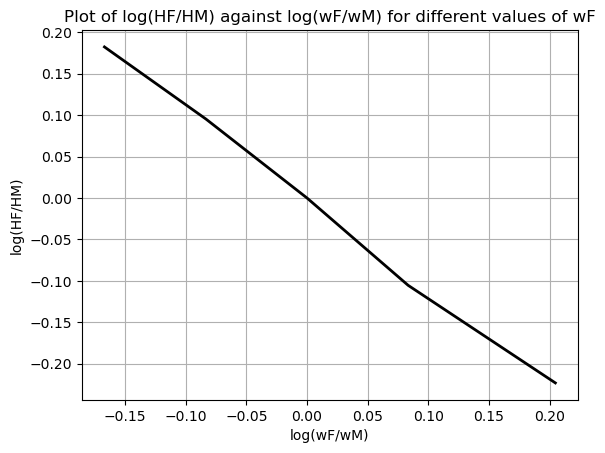

In [15]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(log_Hratio, log_wratio, color='black', lw=2)
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Plot of log(HF/HM) against log(wF/wM) for different values of wF")
plt.show()

In [41]:
model3 = HouseholdSpecializationModelClass()

log_Hratio = []
log_wratio =[]

for wF in model3.par.wF_vec:
    model3.par.wF = wF
    optimum = model3.solve(False, 100)
    log_HFM = np.log(optimum.HF/optimum.HM)
    log_Hratio = np.append(log_Hratio, log_HFM)
    log_wF = np.log(wF/model3.par.wM)
    log_wratio = np.append(log_wratio, log_wF)
    print(wF, log_HFM, log_wF)


0.8 0.24116205681688804 -0.2231435513142097
0.9 0.1010961168713686 -0.10536051565782628
1.0 0.02020270731751947 0.0
1.1 -0.10109611687136863 0.09531017980432493
1.2 -0.2006706954621511 0.1823215567939546
